In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
path = kagglehub.dataset_download("undefinenull/million-song-dataset-spotify-lastfm")

print("Path to dataset files:", path)
data_path = Path(path)

Path to dataset files: /kaggle/input/million-song-dataset-spotify-lastfm


In [3]:
songs_path = data_path / 'Music Info.csv'
user_path = data_path / 'User Listening History.csv'

In [4]:
df_songs = pd.read_csv(songs_path, usecols=['track_id','name','artist','spotify_preview_url'])

In [5]:
!pip install dask[dataframe]

In [6]:
import dask.dataframe as dd
df = dd.read_csv(user_path)
df.head()

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [7]:
df.npartitions

9

In [8]:
unique_tracks_list = df.loc[:, 'track_id'].unique()
unique_tracks_list = unique_tracks_list.compute()
unique_tracks_list = unique_tracks_list.to_list()

In [9]:
unique_users = df.loc[:, 'user_id'].nunique()
unique_users = unique_users.compute()
unique_users

np.int64(962037)

In [10]:
unique_tracks = df.loc[:, 'track_id'].nunique()
unique_tracks = unique_tracks.compute()

In [11]:
df_songs[df_songs['track_id'].isin(unique_tracks_list)]

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
7,TRXOGZT128F424AD74,Karma Police,Radiohead,https://p.scdn.co/mp3-preview/5a09f5390e2862af...
9,TRUJIIV12903CA8848,Clocks,Coldplay,https://p.scdn.co/mp3-preview/24c7fe858b234e3c...
...,...,...,...,...
50675,TRXWSIN128F9339A11,Infinite Love Song,Maximilian Hecker,https://p.scdn.co/mp3-preview/8b3d529025fe3c60...
50677,TRPIGDW12903CDEB2D,Slip of the Lip,Fact,https://p.scdn.co/mp3-preview/cf64490291f9a600...
50678,TRQYCFV128F9322F50,Ryusei Rocket,アンティック-珈琲店-,https://p.scdn.co/mp3-preview/d2668a5a3e0b1fda...
50679,TRHQCSH128F42724B7,Colors Of The Wind,ACIDMAN,https://p.scdn.co/mp3-preview/8e22a7052ef3ecf7...


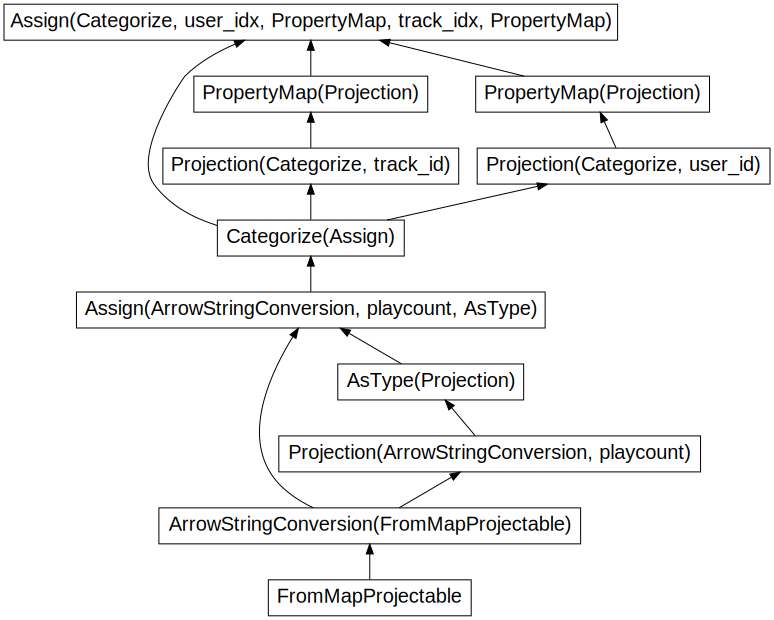

In [12]:
from scipy.sparse import csr_matrix

df['playcount'] = df['playcount'].astype(np.float64)

df = df.categorize(colums = ['track_id','user_id'])

user_mapping = df['user_id'].cat.codes
track_mapping = df['track_id'].cat.codes

df = df.assign(
    user_idx = user_mapping,
    track_idx = track_mapping
)

df.visualize()

In [13]:
df

,track_id,user_id,playcount,user_idx,track_idx
npartitions=9,,,,,
,category[known],category[known],float64,int32,int16
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


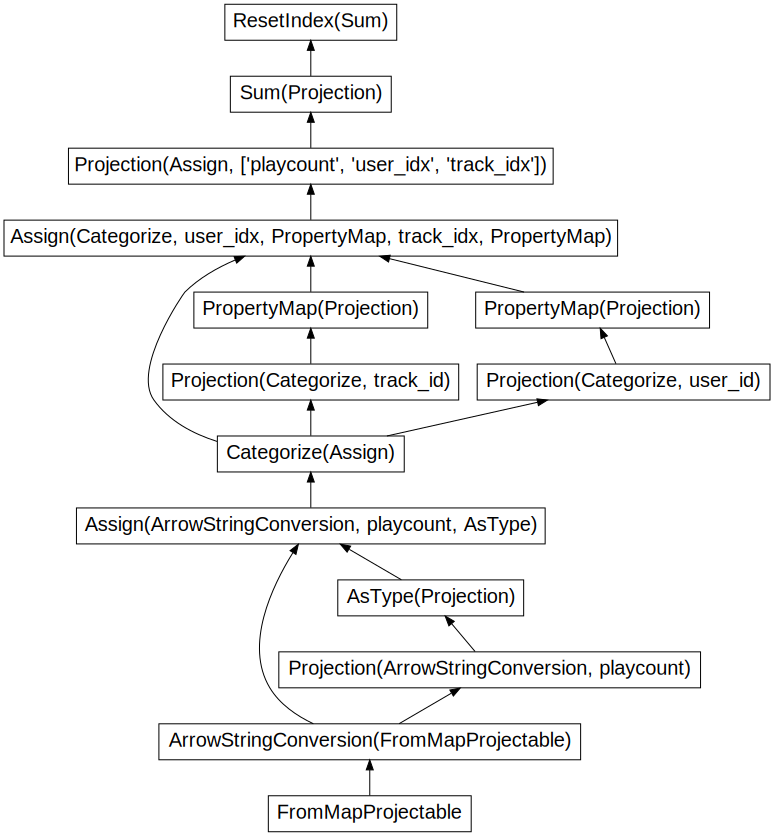

In [14]:
agg_df = df.groupby(['track_idx','user_idx'])['playcount'].sum().reset_index()
agg_df.visualize()

In [15]:
agg_df

,track_idx,user_idx,playcount
npartitions=1,,,
,int16,int32,float64
,...,...,...


In [16]:
agg_df = agg_df.compute()

In [17]:
agg_df

,track_idx,user_idx,playcount
0,0,15780,3.0
1,0,76968,1.0
2,0,134525,2.0
3,0,231541,1.0
4,0,305348,1.0
...,...,...,...
9711296,30458,902360,1.0
9711297,30458,913310,1.0
9711298,30458,922319,1.0
9711299,30458,925779,1.0


In [18]:
row_indices = agg_df['track_idx']
col_indices = agg_df['user_idx']
values = agg_df['playcount']

n_tracks = unique_tracks
n_users = unique_users

sparse_matrix = csr_matrix((values, (row_indices, col_indices)), shape = (n_tracks, n_users))

print('sparse mat shape' , sparse_matrix.shape)
print('Non zero elements', sparse_matrix.nnz)

sparse mat shape (30459, 962037)
Non zero elements 9711301


,track_id,user_id,playcount,user_idx,track_idx
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,10705
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,7334
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,14212
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,23206
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1.0,691377,8936
...,...,...,...,...,...
1079037,TRBKFKL128E078ED76,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1.0,689479,1932
1079038,TRYFXPG128E078ECBD,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1.0,689479,28694
1079039,TROBUUZ128F4263002,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1.0,689479,16702
1079040,TROEWXC128F148C83E,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,1.0,689479,16795


In [27]:
df_songs[df_songs['name'] == "Crazy in Love"]

,track_id,name,artist,spotify_preview_url
6013,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...


In [46]:
track_id = 'TROINZB128F932F740'

np.where(df['track_id'].cat.categories == track_id)

(array([17018]),)

In [47]:
ind = 17018

In [48]:
input_array = sparse_matrix[ind]

input_array

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 610 stored elements and shape (1, 962037)>

In [49]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_score = cosine_similarity(input_array, sparse_matrix)

In [50]:
np.sort(similarity_score)[-6:][::-1]

array([[0.        , 0.        , 0.        , ..., 0.07217127, 0.08225488,
        1.        ]])

In [51]:
np.argsort(similarity_score.ravel())[-6:][::-1]

array([17018, 24529, 28964,  3620,  9470,  7882])

In [52]:
similarity_score.shape

(1, 30459)

In [60]:
recommendations = df['track_id'].cat.categories[np.argsort(similarity_score.ravel())[-6 :][::-1]]

In [61]:
filtered_songs = df_songs[df_songs['track_id'].isin(recommendations)]

In [62]:
filtered_songs

,track_id,name,artist,spotify_preview_url
6013,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...
15899,TRCVMAF12903D00E61,Delirium,Satyricon,https://p.scdn.co/mp3-preview/d039120c4f5f1e8d...
29724,TRGEUXY128F4226B26,Monday Massacre,Mr. Oizo,https://p.scdn.co/mp3-preview/4d6dbacc93e3ef7e...
44767,TRYLWIW12903CA438D,Dreadlock,Future Prophecies,https://p.scdn.co/mp3-preview/13ca5435549b0e46...
44917,TRURCEI12903CA4395,Bring the Noise,Future Prophecies,https://p.scdn.co/mp3-preview/d558b155fb9dcfe4...
46566,TRHRNEE12903CFDBD4,Lunar Sea,Camel,https://p.scdn.co/mp3-preview/8bf35f13a0ece173...


In [78]:
def col_recommendation(song_df,song_name,user_df,sparse_matrix,k):
  if song_df['name'].str.contains(song_name).any():

    song_track_id = song_df[song_df['name']== song_name]['track_id'].values.item()
    ind = np.where(user_df['track_id'].cat.categories == song_track_id)[0][0]
    input_array = sparse_matrix[ind]
    similarity_score = cosine_similarity(input_array, sparse_matrix)
    recommendations = user_df['track_id'].cat.categories[np.argsort(similarity_score.ravel())[-k-1 :][::-1]]
    filtered_songs = song_df[song_df['track_id'].isin(recommendations)]
    return filtered_songs

  else:
    return "Song not found"

In [80]:
col_recommendation(df_songs,"Hips Don't Lie",df,sparse_matrix,6)

,track_id,name,artist,spotify_preview_url
2107,TRUFTBY128F93450B8,Alejandro,Lady Gaga,https://p.scdn.co/mp3-preview/fc79c08bc9f46cca...
2300,TRSUSWW128F93463BF,Imma Be,Black Eyed Peas,https://p.scdn.co/mp3-preview/bb97ba1db66b37e2...
6047,TRAAKDG128F42A0ECB,Hips Don't Lie,Shakira,https://p.scdn.co/mp3-preview/3859547944f57cfb...
6099,TREHENJ128E07953C7,Don't Cha,The Pussycat Dolls,https://p.scdn.co/mp3-preview/7021c37e3e36fe61...
6280,TRQJLCO128F42BCC0A,"Jumpin', Jumpin'",Destiny's Child,https://p.scdn.co/mp3-preview/900921fe7ea36b00...
6477,TRWGTDH128F9314900,Ayo Technology,Milow,https://p.scdn.co/mp3-preview/f47192a476b16087...
35354,TRFPOEN12903CFA6C4,Can't Stop The Killer,Emery,https://p.scdn.co/mp3-preview/12bb12c75a6563f8...
